In [1]:
import os 
import getopt
import sys

import numpy as np
import h5py
import pickle
import random
import copy
import pandas as pd

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, concatenate, Bidirectional, Dense, Dropout, Flatten, Conv1D,BatchNormalization,  MaxPooling1D, Bidirectional, GRU, TimeDistributed
import tensorflow as tf
from tensorflow import keras


np.random.seed(1337) # for reproducibility
vocab = ["A", "G", "C", "T"]
indices = tf.range(len(vocab), dtype = tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocab,indices)
table = tf.lookup.StaticVocabularyTable(table_init, 1)
defs = [0.] * 1 + [tf.constant([], dtype = "string")]

# Nadav dataset


def data_reader(file, batch_size=100, n_parse_threads = 4):
    dataset = tf.data.TextLineDataset(file).skip(1)
    dataset=dataset.map(preprocess, num_parallel_calls = n_parse_threads)
    return dataset.batch(batch_size).prefetch(1)

def preprocess(record):
    fields = tf.io.decode_csv(record, record_defaults=defs)
    chars = tf.strings.bytes_split(fields[1])
    chars_indeces = table.lookup(chars)
    X = tf.one_hot(chars_indeces, depth = len(vocab))
    Y = fields[0]
    return X,Y



2023-10-05 11:18:19.713236: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-05 11:18:19.744832: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-05 11:18:19.744867: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-05 11:18:19.744887: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-05 11:18:19.751203: I tensorflow/core/platform/cpu_feature_g

In [3]:
input_path_train = "/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/mean_with_sequence_ENCFF616IAQ_2col_train.csv"
input_path_valid = '/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/mean_with_sequence_ENCFF616IAQ_2col_test.csv'
input_path_test = '/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/mean_with_sequence_ENCFF616IAQ_2col_test.csv'

# Get first item of the dataset to get the shape of the input data
for element in data_reader(input_path_train):
    input_shape = element[0].shape

inputs = Input(shape=(input_shape[1],input_shape[2]), name="inputs")
layer = Conv1D(250, kernel_size=7, strides=1, activation='relu', name="conv1")(inputs)  # 250 7 relu
layer = Dropout(0.3)(layer)
layer = BatchNormalization()(layer)
layer = Conv1D(250, 8, strides=1, activation='softmax', name="conv2")(layer)  # 250 8 softmax
layer = BatchNormalization()(layer)
layer = MaxPooling1D(pool_size=2, strides=None, name="maxpool1")(layer)
layer = Dropout(0.3)(layer)
layer = Conv1D(250, 3, strides=1, activation='softmax', name="conv3")(layer)  # 250 3 softmax
layer = BatchNormalization()(layer)
layer = Dropout(0.3)(layer)
layer = Conv1D(100, 2, strides=1, activation='softmax', name="conv4")(layer)  # 100 3 softmax
layer = BatchNormalization()(layer)
layer = MaxPooling1D(pool_size=1, strides=None, name="maxpool2")(layer)
layer = Dropout(0.3)(layer)
layer = Flatten()(layer)
layer = Dense(300, activation='sigmoid')(layer)  # 300
layer = Dropout(0.3)(layer)
layer = Dense(200, activation='sigmoid')(layer)  # 300
predictions = Dense(1, activation='linear')(layer)

model = Model(inputs=inputs, outputs=predictions)
model.summary()

model.compile(optimizer="adam",
              loss="mean_squared_error",
              metrics=["mse", "mae", "mape"],
              )

history=model.fit(data_reader(input_path_train,batch_size=1024),
                        epochs=100,
                        validation_data=data_reader(input_path_valid,batch_size=100),
                        callbacks=None,
                        verbose=1)

predicted = model.predict(data_reader(input_path_test,
                                            batch_size=100))

test_data = data_reader(input_path_test,batch_size=100)
test_tensor = X = np.empty(shape=[0,1])
for batch in test_data:
    test_tensor = np.append(test_tensor, batch[1])

import math
def pearson_correlation(x, y):
    n = len(x)
    # Calculate the mean of x and y
    mean_x = sum(x) / n
    mean_y = sum(y) / n
    
    # Calculate the numerator and denominators of the correlation coefficient
    numerator = sum((xi - mean_x) * (yi - mean_y) for xi, yi in zip(x, y))
    denominator_x = math.sqrt(sum((xi - mean_x) ** 2 for xi in x))
    denominator_y = math.sqrt(sum((yi - mean_y) ** 2 for yi in y))
    
    # Calculate the correlation coefficient
    correlation = numerator / (denominator_x * denominator_y)
    return correlation
    
corr_coefficient = pearson_correlation(predicted.flatten(), test_tensor)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 200, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 194, 250)          7250      
                                                                 
 dropout_5 (Dropout)         (None, 194, 250)          0         
                                                                 
 batch_normalization_4 (Bat  (None, 194, 250)          1000      
 chNormalization)                                                
                                                                 
 conv2 (Conv1D)              (None, 187, 250)          500250    
                                                                 
 batch_normalization_5 (Bat  (None, 187, 250)          1000      
 chNormalization)                                          

2023-10-05 11:23:05.448100: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11808208302586189840
2023-10-05 11:23:05.448176: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1737149325073813948


178/178 [==============================] - 23s 103ms/step - loss: 0.2211 - mse: 0.2211 - mae: 0.3578 - mape: 19740.1387 - val_loss: 0.2726 - val_mse: 0.2726 - val_mae: 0.4047 - val_mape: 16728.5488
Epoch 2/100


2023-10-05 11:23:07.578117: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11808208302586189840
2023-10-05 11:23:07.578214: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1737149325073813948


178/178 [==============================] - 17s 97ms/step - loss: 0.1541 - mse: 0.1541 - mae: 0.2999 - mape: 20253.4727 - val_loss: 0.2839 - val_mse: 0.2839 - val_mae: 0.3972 - val_mape: 155.8859
Epoch 3/100
178/178 [==============================] - 17s 96ms/step - loss: 0.1432 - mse: 0.1432 - mae: 0.2885 - mape: 21048.6348 - val_loss: 0.2922 - val_mse: 0.2922 - val_mae: 0.3949 - val_mape: 11644.9316
Epoch 4/100
178/178 [==============================] - 17s 96ms/step - loss: 0.1361 - mse: 0.1361 - mae: 0.2810 - mape: 17262.3359 - val_loss: 0.2098 - val_mse: 0.2098 - val_mae: 0.3377 - val_mape: 12972.1709
Epoch 5/100
178/178 [==============================] - 17s 96ms/step - loss: 0.1313 - mse: 0.1313 - mae: 0.2762 - mape: 17187.4883 - val_loss: 0.1434 - val_mse: 0.1434 - val_mae: 0.2819 - val_mape: 14047.7803
Epoch 6/100
178/178 [==============================] - 17s 94ms/step - loss: 0.1269 - mse: 0.1269 - mae: 0.2719 - mape: 13488.1484 - val_loss: 0.1236 - val_mse: 0.1236 - val_mae:

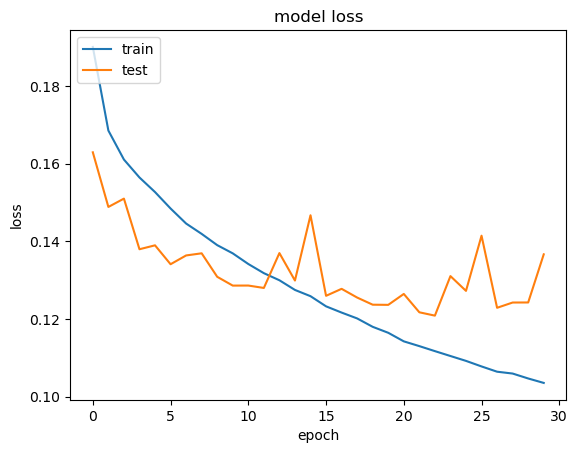

<Figure size 640x480 with 0 Axes>

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
def create_plots(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.clf()
    
create_plots(history)

In [80]:
#Read Data
import shap
_dataset = data_reader("/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/mean_with_sequence_ENCFF616IAQ_2col_test.csv", batch_size=2000)
shuffled_dataset = _dataset.shuffle(5000)
iterator = shuffled_dataset.as_numpy_iterator()
random_sample = next(iterator)
X = random_sample[0]

rn=np.random.choice([X,  X[:,::-1,::-1]][0].shape[0], 1000, replace=False)
explainer = shap.DeepExplainer((model.inputs, model.layers[-1].output), X[rn])
explainer.shap_values(X[0:10], ranked_outputs=1)

#shap_values_top, indexes = explainer.shap_values(X, ranked_outputs=1)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


StagingError: in user code:

    File "/home/felix/anaconda3/envs/tensorflow_2_gpu/lib/python3.9/site-packages/shap/explainers/_deep/deep_tf.py", line 259, in grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)

    LookupError: gradient registry has no entry for: shap_AddV2


(2000, 200, 4)

In [69]:
rn=np.random.choice([X,  X[:,::-1,::-1]][0].shape[0], 200, replace=False)
rn

array([ 823, 1430,   74,  744,  735,  469,  704,  944,  883,  923,   34,
        218,  359,  367, 1444,  527,   89,  442, 1575,  863, 1639, 1948,
       1172,  148, 1635, 1098,  856,  174,   81,  751, 1428, 1471, 1856,
        876, 1805, 1518,  431,  319, 1079, 1205, 1015, 1850,  190, 1893,
       1405, 1906, 1775,  292,  330, 1694,  978, 1659, 1364,  170,  654,
        322,  562, 1020, 1337,   21, 1124,  648, 1779,  518,  982, 1335,
        252,  220,  525,  164,  929,  820, 1606,  732,  619,  181,  132,
       1561, 1576,  154, 1951, 1450,  212,  872,  215, 1665, 1074,  757,
        585,  610, 1842, 1782, 1698,  375, 1674, 1045, 1454,  806, 1184,
       1407, 1433, 1666,  600,  398,  238, 1469,  681,  163,   60, 1861,
        981, 1241, 1866,  198,  115, 1918, 1660,  305, 1942,  104,  102,
       1905, 1699, 1113, 1723,  946,   98, 1930,  912,  376,   99,  511,
       1833, 1025,  812,  851,  512,  256,  601, 1120,    8,  182,  624,
       1118,  315, 1526,  763,  484,  481, 1711,   